# mT5 Model Evaluation using long context without(1.5k) AMR

In [1]:
# Installing required packages
!pip install datasets transformers sentencepiece accelerate -U tensorflow --upgrade torch torchvision peft nltk rouge_score arabert evaluate bert-score > /dev/null 2>&1

In [2]:
# Loading packages
import random
from rouge_score import rouge_scorer
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    default_data_collator,
    MT5Tokenizer,
)
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from google.colab import drive
from bert_score import score

In [3]:
# Path to all the models and datasets
folder_path = '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/'

In [ ]:
# Loading the mT5 tokenizer
tokenizer = MT5Tokenizer.from_pretrained('"Desalegnn/amharic-AMR-mt5-modell"')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Loading a model and its PEFT components and moving it to the current device
model = AutoModelForSeq2SeqLM.from_pretrained(folder_path + "Improved_Amharic_FT")
model = PeftModel.from_pretrained(model, folder_path + "Improved_Amharic_FT")
model.to(device)

# Printing the number of trainable parameters of the model
model.print_trainable_parameters() # Should be 0% trainable, since it is in evaluation mode

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 0 || all params: 301,897,088 || trainable%: 0.0000


In [8]:
# Loading processed data, which includes the preprocessed and tokenized versions of the text and summary entries
tokenized_datasets = DatasetDict.load_from_disk('/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/brand_new_further_cleaned_Amharic_mT5_tokenized_datasets') # This specific file is the preprocessed and tokenized version of Amharic-2

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

In [10]:
# Evaluating the model
model = model.to(device)
model.eval() # Setting the model to evaluation mode
max_target_length = 128 # Setting the maximum target length of the summaries to be generated

# Loading the test data
test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn = default_data_collator,
    batch_size = 64,
    pin_memory = True
)

summaries = [] # List to store generated summaries

# Evaluating the model and saving its results in the summaries list
for step, batch in enumerate(tqdm(test_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
    with torch.no_grad():
        outputs = model.generate(
            input_ids=batch["input_ids"],
            max_new_tokens= max_target_length
        )

    summaries.extend(
        tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)
    )

100%|██████████| 32/32 [02:09<00:00,  4.04s/it]


In [11]:
# Getting the reference summaries to compare the generated summaries with
references = [tokenized_datasets["test"][i]["summary"] for i in range(len(summaries))]

In [12]:
# Saving summaries
# Path can be updated depending on where the generated summaries are to be stored
output_file_path = folder_path + 'improved_amharic_FT_2_generated_summaries.txt'

with open(output_file_path, 'w', encoding='utf-8') as file:
    for summary in summaries:
        file.write(summary + '\n') # newline after each summary

print(f"Summaries saved to {output_file_path}")

Summaries saved to /content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/improved_amharic_FT_2_generated_summaries.txt


In [13]:
# If the model has already been evaluated on a given test set, then there is no need to rerun the model evaluations.
# Can simply load the generated summaries as follows and evaluate them

# Path of the file containing the summaries
input_file_path = folder_path + 'improved_amharic_FT_2_generated_summaries.txt'

# List to hold the summaries
summaries = []

# Reading files and splitting the texts into summaries based on newlines
with open(input_file_path, 'r', encoding='utf-8') as file:
    summaries = file.read().split('\n')

# Removing any empty strings that may result from trailing newlines
summaries = [summary for summary in summaries if summary]

print(f"Loaded {len(summaries)} summaries from {input_file_path}")

Loaded 2001 summaries from /content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/improved_amharic_FT_2_generated_summaries.txt


## Quantitative Evaluations

### ROUGE Scores

ROUGE-2: 0.02937267801232874
ROUGE-L: 0.09357457947988579


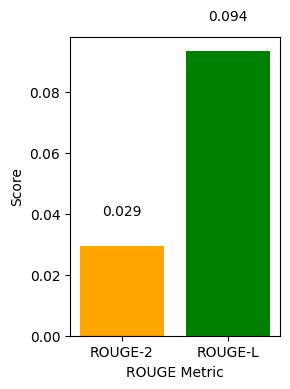

In [14]:
# Initializing Rouge scorer
scorer = rouge_scorer.RougeScorer(["rouge2", "rougeLsum"], use_stemmer=True)

# Calculating ROUGE scores
import matplotlib.pyplot as plt

# Calculate ROUGE Scores
rouge_scores = [
    scorer.score(summary, reference) for summary, reference in zip(summaries, references)
]

rouge2 = sum([score["rouge2"].fmeasure for score in rouge_scores]) / len(rouge_scores)  # Average ROUGE-2
rougeLsum = sum([score["rougeLsum"].fmeasure for score in rouge_scores]) / len(rouge_scores)  # Average ROUGE-L

# Print the Average ROUGE Scores
print(f"ROUGE-2: {rouge2}")
print(f"ROUGE-L: {rougeLsum}")

# Step to create the bar graph
# Data for the bar graph
rouge_labels = ['ROUGE-2', 'ROUGE-L']
rouge_values = [rouge2, rougeLsum]

# Creating the bar graph
plt.figure(figsize=(3, 4))
plt.bar(rouge_labels, rouge_values, color=['orange', 'green'])

# Adding the title and labels
plt.ylabel('Score')
plt.xlabel('ROUGE Metric')

# Display the value of each bar at the top
for i, value in enumerate(rouge_values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center')

# Show the graph
plt.tight_layout()
plt.show()


### BLEU Score

In [15]:
# Prepare the reference and candidate sentences for BLEU
list_of_references = [[ref.split()] for ref in references]  # BLEU expects a list of lists of tokens
candidates = [summary.split() for summary in summaries]

# Compute the BLEU-4 score using the NLTK function
bleu_score = corpus_bleu(list_of_references, candidates,
                         smoothing_function=SmoothingFunction().method1)

print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.3794849223345656


### BERTScores (Precision, Recall and F1)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Precision: 0.7448670864105225
 Recall: 0.7081663608551025
F1: 0.7226200103759766


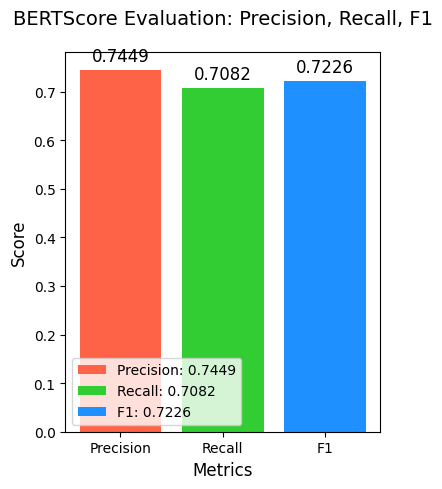

In [ ]:
import matplotlib.pyplot as plt
from bert_score import score

# Assuming `summaries` contains your generated summaries and `references` contains the reference summaries
P, R, F1 = score(summaries, references, model_type="Desalegnn/amharic-AMR-mt5-modell")

# Calculate average Precision, Recall, and F1
avg_precision = sum(P) / len(P)
avg_recall = sum(R) / len(R)
avg_f1 = sum(F1) / len(F1)
# Print the Average ROUGE Scores
print(f"Precision: {avg_precision}")
print(f" Recall: {avg_recall}")
print(f"F1: {avg_f1}")

# Create a smart bar graph for BERTScore (Precision, Recall, F1)
labels = ['Precision', 'Recall', 'F1']
averages = [avg_precision, avg_recall, avg_f1]
all_scores = [P, R, F1]

# Define colors for each bar (chosen to be more aesthetic)
colors = ['#FF6347', '#32CD32', '#1E90FF']  # Tomato, LimeGreen, DodgerBlue

# Create a bar chart
plt.figure(figsize=(4, 5))

# Plot the bar graph for each metric (Precision, Recall, F1) and their averages
bars = []
for i, score_list in enumerate(all_scores):
    avg_score = sum(score_list) / len(score_list)
    bar = plt.bar(labels[i], avg_score, color=colors[i], label=f"{labels[i]}: {avg_score:.4f}")
    bars.append(bar)

# Add text with the value of the score on top of the bar
for i, bar in enumerate(bars):
    height = bar[0].get_height()  # Accessing the height of the first bar in the container
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, height + 0.01, f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, color='black')

# Add the title at the top of the graph
plt.title('BERTScore Evaluation: Precision, Recall, F1', fontsize=14, pad=20)

# Customize the chart with labels
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Add legend to show which color corresponds to which score
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [17]:
# Displaying some example summaries along with their corresponding BERTScores
random.seed(16)

for i in range(5):
    index = random.randint(0, len(summaries) - 1)

    print(f"Reference Summary: {references[index]}")
    print(f"Generated Summary: {summaries[index]}")
    print(f"Precision: {P[index]}, Recall: {R[index]}, F1 Score: {F1[index]}")
    print("========================================")

Reference Summary: ዛሬ አርባምንጭ ላይ የመጀመሪያ ጉባዔውን ያካሄደውና በሕዝበ ውሳኔ የተቋቋመው የደቡብ ኢትዮጵያ ክልል ምክር ቤት ብቸኛ ዕጩ ኾነው የቀረቡትን ጥላሁን ከበደን የክልሉ የመጀመሪያው ርዕሰ መስተዳድር አድርጎ መርጧል።ምክር ቤቱ በተመሳሳይ ጸሃይ ወራሳን አፈ ጉባዔው አድርጎ መርጧል።
Generated Summary: <extra_id_0> ዛሬ አርባምንጭ ላይ የመጀመሪያ ጉባኤውን ያካሄደውና በህዝበ ውሳኔ የተቋቋመው የደቡብ ክልል ምክር ቤት ብቸኛ እጩ ሆነው የቀረቡትን ጥላሁን ከበደን የክልሉ የመጀመሪያው ርእሰ መስተዳድር አድርጎ መርጧል።
Precision: 0.8757373094558716, Recall: 0.8050608038902283, F1 Score: 0.8389131426811218
Reference Summary:   መንግስት ከሁሉም የህብረተሰብ ክፍል ጋር በጋራ ለመስራት ያቀረበውን አገራዊ ጥሪ በመቀበል ለአገራችን ህዳሴ መትጋት አለብን ሲሉ ዋልታ ቴሌቪዥን ያነጋገራቸው የኢትዮጲያ ዲያሰፖራ ማህበር አባላት ጥሪ አቅርበዋል ፡፡
Generated Summary: <extra_id_0> ከሁሉም የህብረተሰብ ክፍል ጋር በጋራ ለመስራት ያቀረበውን አገራዊ ጥሪ በመቀበል ለበርካታ ዜጎች የስራ እድል በመፍጠር ላይ ይገኛል
Precision: 0.7718249559402466, Recall: 0.6509349942207336, F1 Score: 0.7062439918518066
Reference Summary:     በአዲስ አበባ ከተማ ከኃይሌ ጋርመንት እስከ ጀሞ 3 እየተገነባ ያለው መንገድ የወሰን ማስከበር ችግር እንደገጠመው ተገለጸ፡፡ለዚህ ደግሞ በመንገድ ግንባታው አካባቢ ሶስት ቦታዎች ላይ ያሉ 200 የሚሆኑ ቤቶች ባለመፍረሳቸው ግንባታውን እንዲጓተት አድርጓል ነው የተባለው፡፡
Gener

In [ ]:
!pip install gradio
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel

# ✅ Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# ✅ Summarization function
def generate_summary(text, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=max_length)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ✅ Gradio Interface
gr.Interface(
    fn=generate_summary,
    inputs=[
        gr.Textbox(lines=10, label="Enter Amharic Text"),
        gr.Slider(32, 512, value=128, label="Max Summary Length")
    ],
    outputs=gr.Textbox(lines=5, label="Generated Summary"),
    title="Amharic Summarization (mT5 + LoRA PEFT)",
    description="Enter Amharic text. The model will summarize it using a fine-tuned mT5 with LoRA."
).launch()
